In [ ]:
import numpy as np                                          # type: ignore
import pandas as pd                                         # type: ignore
import matplotlib.pyplot as plt                             # type: ignore
from pathlib import Path                                    # type: ignore    
import cv2                                                  # type: ignore
    
from PIL import Image                                       # type: ignore 
from scipy import ndimage as ndi                            # type: ignore
from skimage.filters import sobel, rank                     # type: ignore
from skimage.morphology import disk                         # type: ignore
from skimage.segmentation import watershed, felzenszwalb    # type: ignore

from sklearn.metrics import accuracy_score, f1_score        # type: ignore
from sklearn.cluster import KMeans, MeanShift               # type: ignore
from sklearn.decomposition import PCA                       # type: ignore

from tqdm import tqdm                                       # type: ignore
import torch                                                # type: ignore              

c:\Users\sacha\miniconda3\envs\ECN_APP_PROF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Loading

In [2]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [3]:
data_train_path = Path('data/images_hTE3Lse/images')
data_test_path = Path('data/images_ZKlXDOZ/images')

data_train = load_dataset(data_train_path)
print("Loaded data_train:", data_train.shape)
data_test = load_dataset(data_test_path)
print("Loaded data_test:", data_test.shape)

Loaded data_train: (2000, 512, 512)
Loaded data_test: (500, 512, 512)


In [4]:
# Load half-supervised labels
labels = pd.read_csv(
    'data/label_rphifOX.csv',
    index_col=0,
)
print("Loaded labels:", labels.shape)
labels = labels.T
labels.head()

Loaded labels: (262144, 2000)


,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Display the first 5 label maps
sum_per_line = labels.sum(axis=1)
index_supervised = sum_per_line[sum_per_line > 0].index
print("Count with labels:", len(index_supervised))
print("Indexes with labels:", index_supervised.tolist())


Count with labels: 400
Indexes with labels: ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.p

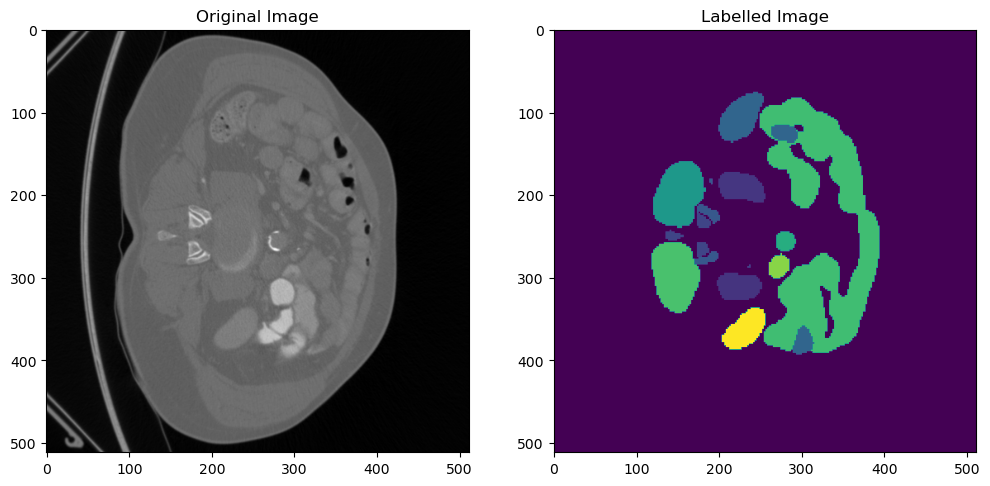

In [6]:
def label_to_image(label):
    return label.to_numpy().reshape(512, 512)

test = labels.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(data_train[0], cmap='gray')
axs[0].set_title('Original Image')

# Plot the label image
axs[1].imshow(label_to_image(test))
axs[1].set_title('Labelled Image')

plt.show()